In [1]:
import pandas as pd
import datetime as dt
import numpy as np

from csv import writer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('xrp.csv')
print(df)

      Unnamed: 0 formatted_date      high       low      open     close  \
0              0     2019-01-01  0.364771  0.350402  0.365675  0.364771   
1              1     2019-01-02  0.378021  0.359574  0.374505  0.375243   
2              2     2019-01-03  0.374505  0.357675  0.359753  0.360224   
3              3     2019-01-04  0.364642  0.352785  0.356347  0.356747   
4              4     2019-01-05  0.361069  0.353987  0.354750  0.355275   
...          ...            ...       ...       ...       ...       ...   
1515        1515     2023-02-24  0.390547  0.374133  0.378507  0.378477   
1516        1516     2023-02-25  0.379419  0.372250  0.378085  0.378085   
1517        1517     2023-02-26  0.380606  0.375420  0.378005  0.378041   
1518        1518     2023-02-27  0.380042  0.372158  0.379121  0.379115   
1519        1519     2023-02-28  0.382433  0.373027  0.377133  0.377150   

          volume  adjclose  
0      449347622  0.364771  
1      543216669  0.375243  
2      43887

In [3]:
# Process data
df['H-L'] = df['high'] - df['low']
# df['O-C'] = df['open'] - df['close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df['close'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['close'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['close'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['close'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['close'].rolling(window=ma_3).std()
df.dropna(inplace=True)
df

,Unnamed: 0,formatted_date,high,low,open,close,volume,adjclose,H-L,SMA_7,SMA_14,SMA_21,SD_7,SD_21
20,20,2019-01-21,0.322593,0.317439,0.321078,0.320790,363940431,0.320790,0.005154,0.326211,0.333262,0.343365,0.004171,0.019658
21,21,2019-01-22,0.321078,0.313455,0.319566,0.319491,434125854,0.319491,0.007623,0.325113,0.329989,0.341209,0.004834,0.019676
22,22,2019-01-23,0.320303,0.314923,0.316416,0.316492,375671478,0.316492,0.005380,0.323226,0.326103,0.338411,0.005300,0.018750
23,23,2019-01-24,0.318896,0.314433,0.317859,0.317598,344960253,0.317598,0.004463,0.321547,0.325028,0.336382,0.004881,0.018577
24,24,2019-01-25,0.319069,0.313824,0.317260,0.317165,360076505,0.317165,0.005245,0.320531,0.323904,0.334497,0.004957,0.018415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,1515,2023-02-24,0.390547,0.374133,0.378507,0.378477,953355531,0.378477,0.016414,0.390653,0.387840,0.390471,0.006746,0.010021
1516,1516,2023-02-25,0.379419,0.372250,0.378085,0.378085,552223148,0.378085,0.007169,0.388289,0.387416,0.388889,0.007917,0.009152
1517,1517,2023-02-26,0.380606,0.375420,0.378005,0.378041,441815645,0.378041,0.005186,0.387107,0.387614,0.387894,0.008827,0.009141
1518,1518,2023-02-27,0.380042,0.372158,0.379121,0.379115,1049508853,0.379115,0.007884,0.384334,0.388145,0.387241,0.007606,0.009260


In [4]:
pre_day = 7
scala_x = MinMaxScaler(feature_range=(0,1))
scala_y = MinMaxScaler(feature_range=(0,1))
cols_x = ['high','low','open','H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['close']
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

x_total = []
y_total = []

for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])

# test_size = (int)(len(scaled_data_y) * 0.2)
# print(test_size)

# x_train = np.array(x_total[:len(x_total)])
# # x_test = np.array(x_total[len(x_total)-test_size:])
# y_train = np.array(y_total[:len(y_total)])
# # y_test = np.array(y_total[len(y_total)-test_size:])

test_size = (int)(len(scaled_data_y) * 0.2)
print(test_size)

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])



print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

300
(1193, 7, 9) (1193, 1) (300, 7, 9) (300, 1)


In [5]:
# Build model
model = Sequential()

model.add(GRU(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=120, steps_per_epoch=40, use_multiprocessing=True)
# model.save("../../model/BOOSTING/GRU_boosting_close.h5")

Epoch 1/120
40/40 [==============================] - 18s 20ms/step - loss: 0.0107
Epoch 2/120
40/40 [==============================] - 1s 19ms/step - loss: 0.0050
Epoch 3/120
40/40 [==============================] - 1s 17ms/step - loss: 0.0045
Epoch 4/120
40/40 [==============================] - 1s 16ms/step - loss: 0.0042
Epoch 5/120
40/40 [==============================] - 1s 25ms/step - loss: 0.0035
Epoch 6/120
40/40 [==============================] - 1s 31ms/step - loss: 0.0045
Epoch 7/120
40/40 [==============================] - 1s 21ms/step - loss: 0.0034
Epoch 8/120
40/40 [==============================] - 1s 25ms/step - loss: 0.0030
Epoch 9/120
40/40 [==============================] - 1s 22ms/step - loss: 0.0029
Epoch 10/120
40/40 [==============================] - 1s 29ms/step - loss: 0.0031
Epoch 11/120
40/40 [==============================] - 1s 28ms/step - loss: 0.0027
Epoch 12/120
40/40 [==============================] - 1s 19ms/step - loss: 0.0030
Epoch 13/120
40/40 [====

In [6]:
# Testing
predict_price = model.predict(x_train)
predict_price = scala_y.inverse_transform(predict_price)
y_train_price = scala_y.inverse_transform(y_train)

error = pd.concat([pd.DataFrame(predict_price,columns=['predict_price'],index=None), pd.DataFrame(y_train_price,columns=['y_train_price'],index=None)], axis=1)
error['error_price'] = error['predict_price'] - error['y_train_price']
print(error)

38/38 [==============================] - 24s 8ms/step
      predict_price  y_train_price  error_price
0          0.317205       0.294863     0.022342
1          0.306518       0.289558     0.016960
2          0.299869       0.320461    -0.020592
3          0.323101       0.310036     0.013065
4          0.315517       0.308517     0.007000
...             ...            ...          ...
1188       0.594007       0.587091     0.006916
1189       0.575274       0.607844    -0.032570
1190       0.576639       0.614269    -0.037630
1191       0.581690       0.604849    -0.023159
1192       0.579539       0.646474    -0.066935

[1193 rows x 3 columns]


In [7]:

from sklearn.linear_model import ElasticNet
import pickle
elasticnet =  ElasticNet(alpha= 0.01, l1_ratio= 0.8, positive= True, random_state= 100, selection= 'random', tol= 0.2, warm_start= True)

In [8]:
elasticnet.fit(error['predict_price'].values.reshape(-1, 1), error['error_price'].values)
# pickle.dump(elasticnet, open("../../model/BOOSTING/booting_elasticnet_close.h5", "wb"))

ElasticNet(alpha=0.01, l1_ratio=0.8, positive=True, random_state=100,
           selection='random', tol=0.2, warm_start=True)

In [9]:
predict_price = model.predict(x_test)
print(predict_price)

10/10 [==============================] - 0s 13ms/step
[[0.27652714]
 [0.25388634]
 [0.25633222]
 [0.2462419 ]
 [0.24019776]
 [0.21312612]
 [0.21112111]
 [0.16460302]
 [0.14257482]
 [0.16267644]
 [0.15044934]
 [0.16473208]
 [0.15832654]
 [0.16122939]
 [0.15703349]
 [0.15592359]
 [0.15779294]
 [0.1547288 ]
 [0.15912606]
 [0.15447815]
 [0.15230563]
 [0.1536582 ]
 [0.14716373]
 [0.14608917]
 [0.14354154]
 [0.144824  ]
 [0.15995832]
 [0.16199432]
 [0.15106145]
 [0.15200971]
 [0.14535214]
 [0.14441842]
 [0.14700466]
 [0.14996378]
 [0.15049604]
 [0.14927204]
 [0.1492321 ]
 [0.14373878]
 [0.13302346]
 [0.12424938]
 [0.1080706 ]
 [0.10505608]
 [0.11292981]
 [0.10099992]
 [0.10699768]
 [0.09796004]
 [0.10745454]
 [0.10663673]
 [0.11247874]
 [0.10731204]
 [0.11661608]
 [0.13627885]
 [0.12919652]
 [0.13044462]
 [0.12564069]
 [0.11904268]
 [0.11418828]
 [0.1119417 ]
 [0.10713316]
 [0.10475157]
 [0.10781068]
 [0.10965044]
 [0.10973124]
 [0.11386055]
 [0.11894593]
 [0.12075348]
 [0.1205257 ]
 [0.1127

In [10]:



predict_error = elasticnet.predict(predict_price)
index=0
predict_price = scala_y.inverse_transform(predict_price)
for error in predict_error:
    predict_price[index]+=error
    index+=1
print(predict_price)



[[0.600541  ]
 [0.56206065]
 [0.5662177 ]
 [0.54906815]
 [0.53879553]
 [0.4927846 ]
 [0.48937687]
 [0.4103147 ]
 [0.37287554]
 [0.40704027]
 [0.38625908]
 [0.41053405]
 [0.39964718]
 [0.40458086]
 [0.3974495 ]
 [0.39556313]
 [0.39874026]
 [0.39353245]
 [0.40100604]
 [0.39310643]
 [0.38941404]
 [0.39171284]
 [0.38067487]
 [0.37884852]
 [0.37451857]
 [0.37669826]
 [0.40242055]
 [0.40588093]
 [0.38729942]
 [0.3889111 ]
 [0.37759587]
 [0.37600893]
 [0.3804045 ]
 [0.38543382]
 [0.38633844]
 [0.38425815]
 [0.38419026]
 [0.3748538 ]
 [0.35664204]
 [0.3417296 ]
 [0.3142321 ]
 [0.30910864]
 [0.32249084]
 [0.3022148 ]
 [0.31240857]
 [0.2970482 ]
 [0.31318507]
 [0.31179512]
 [0.3217242 ]
 [0.31294286]
 [0.328756  ]
 [0.3621749 ]
 [0.35013777]
 [0.35225904]
 [0.34409428]
 [0.3328803 ]
 [0.32462975]
 [0.32081145]
 [0.31263885]
 [0.3085911 ]
 [0.31379035]
 [0.3169172 ]
 [0.31705457]
 [0.32407272]
 [0.33271584]
 [0.33578795]
 [0.33540082]
 [0.32214704]
 [0.31387338]
 [0.30914092]
 [0.31483507]
 [0.31

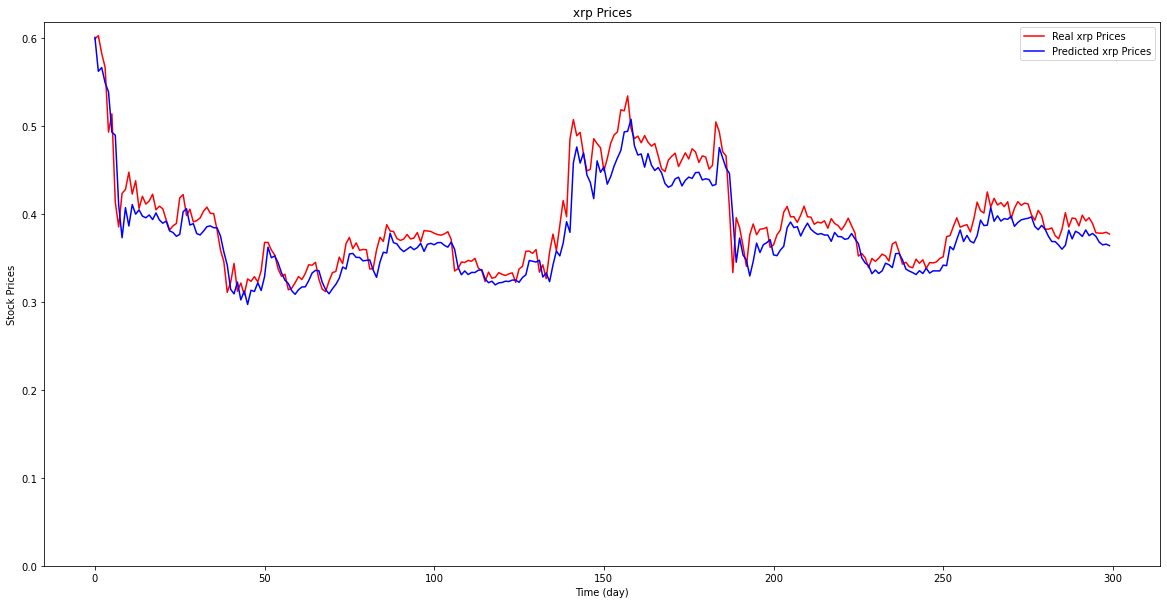

In [11]:
y_test = scala_y.inverse_transform(y_test)
plt.figure(figsize=(20,10))
plt.plot(y_test, color="red", label=f"Real xrp Prices")
plt.plot(predict_price[0:], color="blue", label=f"Predicted xrp Prices")
plt.title(f"xrp Prices")
plt.xlabel("Time (day)")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()

TEST

In [12]:
mae = mean_absolute_error(y_test, predict_price)
mape = mean_absolute_percentage_error(y_test, predict_price)
mse = mean_squared_error(y_test, predict_price)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predict_price)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.02
MAPE: 4.27%
MSE: 0.00
RMSE: 0.02
R2: 0.83


In [13]:
# predict_price_test = model.predict(x_test)
# predict_price_test = scala_y.inverse_transform(predict_price_test)
# y_test = scala_y.inverse_transform(y_test)



In [14]:
# validate = []
# for predict in predict_price_test:
#     predict= elasticnet.predict(np.array([predict]).reshape(-1,1))[0]
#     validate.append(predict)
# df_predict = pd.concat([pd.DataFrame(predict_price_test,columns=['predict_price_test'],index=None), pd.DataFrame(y_test,columns=['y_test'],index=None)], axis=1)
# df_predict['final_predict'] = df_predict['predict_price_test'] + validate
# print(df_predict.to_csv('result.csv'))